In [1]:

import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean , get_MOI, get_MOI_2D, get_SHM_invariance_2D
from invariance_functions import degree_of_freedom, get_GPR_model_2D, get_SHM_data_2D, get_double_pendulum_data, evaluate_model_future_2D, evaluate_model_grid_2D, SHM_dynamics1_2D, SHM_dynamics2_2D, get_GPR_model_GD_2D
from local_invariance_kernels import  get_polynomial_local_invariance_2D, get_SHM_local_invariance_2D, get_double_pendulum_local_invariance
from parameterised_invariance_kernels import get_polynomial_invariance_2D
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = '5'

In [2]:

mean = ZeroMean(4) 

time_step = 0.01
training_time = 0.1
testing_time = 1

max_x = 3
max_v = 0.3
n_train = 3
train_starting_position1 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_position2 = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity1 = np.random.uniform(-max_v, max_v, (n_train))
train_starting_velocity2 = np.random.uniform(-max_v, max_v, (n_train))

print(train_starting_position1)
print(train_starting_position2)
print(train_starting_velocity1)
print(train_starting_velocity2)

data2 = get_SHM_data_2D(time_step, training_time, 1e-8, train_starting_position1, train_starting_position2, train_starting_velocity1, train_starting_velocity2) #switch


[ 2.55461182 -2.56311835  1.60875393]
[ 2.79587625  2.04478046 -0.44921754]
[0.07009784 0.08202654 0.01648941]
[-0.00070213 -0.29979248  0.23362056]


In [3]:

scalerX = StandardScaler(with_mean=False, with_std=False).fit(data2[0])
scalerY = StandardScaler(with_mean=False, with_std=False).fit(data2[1])
#scalerX = MinMaxScaler((-1,1)).fit(data2[0])
#scalerY = MinMaxScaler((-1,1)).fit(data2[1])
X = scalerX.transform(data2[0])
Y = scalerY.transform(data2[1])
data = (X, Y)
scalers = (scalerX, scalerY)
time_setting = (testing_time, time_step)
dynamics = (SHM_dynamics1_2D, SHM_dynamics2_2D)
jitter = 5e-4

#joblib.dump(scalerX, 'shm_2d/scalerX.gz')
#joblib.dump(scalerY, 'shm_2d/scalerY.gz')

In [4]:

print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())
#try:
n_neighbours =  20
print("known")
kernel_known = get_SHM_local_invariance_2D(3, 6, 0, 1, n_neighbours, jitter) #switch
#kernel_known = get_SHM_invariance_2D(1, n_neighbours, jitter) #switch
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())

polynomial_degree = 1
print("learnt")
#    X, Y = data
kernel = get_polynomial_local_invariance_2D(3, 6, 0, 1, n_neighbours, jitter, polynomial_degree) 
#kernel = get_polynomial_invariance_2D(1, n_neighbours, jitter, polynomial_degree) 
model = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known)
print(model.log_marginal_likelihood().numpy())
#    model = get_GPR_model_2D(kernel, mean, data, iterations=10000, old_kernel=kernel_known)
#    ckpt = tf.train.Checkpoint(model=model)
#    manager = tf.train.CheckpointManager(ckpt, "shm_2d", max_to_keep=3)
#    model = get_GPR_model_GD_2D(model=model, iterations=10000, lr=0.001, manager=manager)
#    print(model.log_marginal_likelihood().numpy())
#except tf.errors.InvalidArgumentError:
#    print("jitter too small")

moi
423.111770410926
known
471.8880187893922
learnt
468.7022635262546


In [19]:

eva_future_moi = []
eva_future_known = []
eva_future_learnt = []

def energy(X):
    return 0.5*(tf.square(X[:,0])+tf.square(X[:,1])+tf.square(X[:,2])+tf.square(X[:,3]))
for i in range(1):
    print(i)
    test_starting_position1 = np.random.uniform(-max_x, max_x)
    test_starting_position2 = np.random.uniform(-max_x, max_x)
    test_starting_velocity1 = np.random.uniform(-max_v, max_v)
    test_starting_velocity2 = np.random.uniform(-max_v, max_v)
    test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)
    print(test_starting)
    evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_moi.append(evaluate_moi[0])
    print(evaluate_moi[0])
    evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_known.append(evaluate_known[0])
    print(evaluate_known[0])
    evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
    eva_future_learnt.append(evaluate_learnt[0])
    print(evaluate_learnt[0])

0
(-2.184724296901475, 2.5316648598891813, 0.29904069569908837, 0.008979917515401337)
0.3119254911017164g
0.0007313269060780727
0.0005527952920246416


In [5]:

lml_moi = moi.log_marginal_likelihood().numpy()
lml_inv = known.log_marginal_likelihood().numpy()
lml_inv_p = model.log_marginal_likelihood().numpy()
print("Log Marginal Likelihood & " + format((lml_moi),".2f")+" & "+ format((lml_inv),".2f") + " & "+ format((lml_inv_p),".2f") + " & "+' \\\\')
print("MSE & "+ format((np.mean(eva_future_moi)),".4f")+" & "+format(np.mean(eva_future_known),".4f")+" & "+format((np.mean(eva_future_learnt)),".4f")+ ' \\\\')

Log Marginal Likelihood & 456.34 & 500.54 & 496.89 &  \\


NameError: name 'eva_future_moi' is not defined

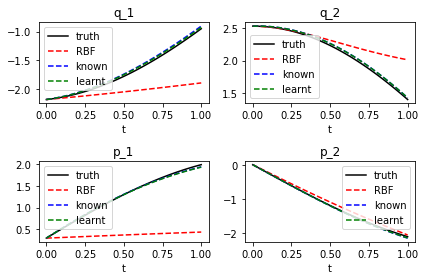

In [21]:

import matplotlib.pyplot as plt
t = np.linspace(0, testing_time, int(testing_time/time_step))
fig, axs = plt.subplots(2,2)
axs[0][0].plot(t,evaluate_known[4][:,0],label="truth", color="black")
axs[0][0].plot(t,evaluate_moi[1][:,0], "--", label="RBF", color="red")
axs[0][0].plot(t,evaluate_known[1][:,0], "--", label="known", color="blue")
axs[0][0].plot(t,evaluate_learnt[1][:,0], "--", label="learnt", color="green")
axs[0][0].set_title("q_1")
axs[0][0].set_xlabel("t")
axs[0][0].legend()

axs[0][1].plot(t,evaluate_known[4][:,1],label="truth", color="black")
axs[0][1].plot(t,evaluate_moi[1][:,1], "--", label="RBF", color="red")
axs[0][1].plot(t,evaluate_known[1][:,1], "--", label="known", color="blue")
axs[0][1].plot(t,evaluate_learnt[1][:,1], "--", label="learnt", color="green")
axs[0][1].set_title("q_2")
axs[1][1].set_xlabel("t")
axs[0][1].legend()

axs[1][0].plot(t,evaluate_known[4][:,2],label="truth", color="black")
axs[1][0].plot(t,evaluate_moi[1][:,2], "--", label="RBF", color="red")
axs[1][0].plot(t,evaluate_known[1][:,2], "--", label="known", color="blue")
axs[1][0].plot(t,evaluate_learnt[1][:,2], "--", label="learnt", color="green")
axs[1][0].set_title("p_1")
axs[1][0].set_xlabel("t")
axs[1][0].legend()

axs[1][1].plot(t,evaluate_known[4][:,3],label="truth", color="black")
axs[1][1].plot(t,evaluate_moi[1][:,3], "--", label="RBF", color="red")
axs[1][1].plot(t,evaluate_known[1][:,3], "--", label="known", color="blue")
axs[1][1].plot(t,evaluate_learnt[1][:,3], "--", label="learnt", color="green")
axs[1][1].set_title("p_2")
axs[0][1].set_xlabel("t")
axs[1][1].legend()

plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
fig.tight_layout()
#plt.savefig("figures/shm_2d_predicted.pdf")


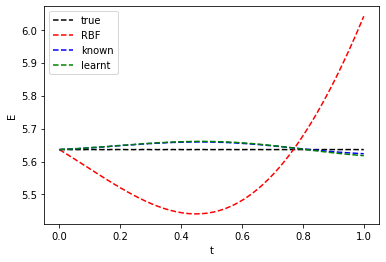

In [23]:

plt.plot(t, evaluate_learnt[5], "--",label="true", color="black")
plt.plot(t, evaluate_moi[6], "--",label="RBF", color="red")
plt.plot(t, evaluate_known[6], "--",label="known", color="blue")
plt.plot(t, evaluate_learnt[6], "--",label="learnt", color="green")
plt.legend()
plt.xlabel("t")
plt.ylabel("E")
#plt.savefig("figures/shm_2d_energy.pdf")

In [56]:
n_neighbours = 20
def energy(X):
    return 0.5*(tf.square(X[:,0])+tf.square(X[:,1])+tf.square(X[:,2])+tf.square(X[:,3]))
print("moi")
moi = get_GPR_model_2D(get_MOI_2D(), mean, data, 100)
print(moi.log_marginal_likelihood().numpy())

print("known")
kernel_known = get_SHM_local_invariance_2D(3, 6, 0, 1, n_neighbours, jitter) #switch
known = get_GPR_model_2D(kernel_known, mean, data, iterations=1000)
print(known.log_marginal_likelihood().numpy())


kernel = get_polynomial_local_invariance_2D(3, 6, 0, 1, n_neighbours, jitter, polynomial_degree) 
model = get_GPR_model_2D(kernel, mean, data, iterations=1000, old_model=known, fixed=True)

print(model.log_marginal_likelihood().numpy())


polynomial_degree = 1
print("learnt")
test_starting_position1 = np.random.uniform(-max_x, max_x)
test_starting_position2 = np.random.uniform(-max_x, max_x)
test_starting_velocity1 = np.random.uniform(-max_v, max_v)
test_starting_velocity2 = np.random.uniform(-max_v, max_v)
test_starting = (test_starting_position1, test_starting_position2, test_starting_velocity1, test_starting_velocity2)

evaluate_moi = evaluate_model_future_2D(moi, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_moi[0])
evaluate_known = evaluate_model_future_2D(known, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_known[0])
evaluate_learnt = evaluate_model_future_2D(model, test_starting, dynamics, time_setting, scalers, energy)
print(evaluate_learnt[0])


grids_lml = []
grids_eva = []
for i in range(50):
    print(i)
    kernel_grid = get_polynomial_local_invariance_2D(3, 6, 0, 1, n_neighbours, jitter, polynomial_degree) 
    kernel_grid.poly = gpflow.Parameter(0.1*np.random.normal(size=kernel_grid.poly.shape), transform =tfp.bijectors.Sigmoid(to_default_float(-1.), to_default_float(1.)), trainable=False, prior=tfp.distributions.Laplace(to_default_float(0),(0.1)), name="poly")
    model_grid = get_GPR_model_2D(kernel_grid, mean, data, iterations=1000, old_model=known, fixed=True)
    print(model_grid.log_marginal_likelihood().numpy())

    evaluate_learnt_grid = evaluate_model_future_2D(model_grid, test_starting, dynamics, time_setting, scalers, energy)
    print(evaluate_learnt_grid[0])
    grids_eva.append(evaluate_learnt_grid[0])
    grids_lml.append(model_grid.log_marginal_likelihood().numpy())

kernel_free = get_polynomial_local_invariance_2D(3, 6, 0, 1, n_neighbours, jitter, polynomial_degree) 
model_free = get_GPR_model_2D(kernel_free, mean, data, iterations=1000, old_model=known)
evaluate_learnt_free = evaluate_model_future_2D(model_free, test_starting, dynamics, time_setting, scalers, energy)

moi
440.4733174454094
known
486.41445033212494
483.02649140555155
learnt
0.06242364594672588
0.008053833328959037
0.008082859761887556
0
-28868.74190622845
1.3814471650487585gg
1
-9750.851109682546
0.09183764331021171g
2
-47196.15674606194
1.7933616313450946gg
3
-91399.45340800754
1.788050296432127ngg
4
-198993.48265605394
2.621175912642848ngg
5
-48127.71449405209
0.5491298930629844gg
6
-138220.8353643127
0.6938305265939051gg
7
-33627.80696955161
0.5246915472166522gg
8
-38337.92332352568
7.02914179546443ingg
9
-30132.09717593261
0.4982768605946296gg
10
-125245.96970498016
1.028504633204831ngg
11
-12199.954911412808
2.7843205881106816gg
12
-80987.09930746701
0.5416248258799167gg
13
-92300.79187830628
0.9680664821318044gg
14
-274864.9001020773
50.589802513541024gg
15
-8947.056674329611
0.14526531707399182g
16
-98609.61543630641
1.15899928761703ingg
17
-16496.85932877864
7.414581442707664ngg
18
-92807.9177979217
21.79037204912761ngg
19
-66821.43096069133
1.7436352584940773gg
20
-31300.671

/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


0.604014057518469
26
-57754.29591070061
1.539502352827422ngg
27
-172683.19777885874
1.2715533822332383gg
28
-71098.66276613866
7.429873006968645ngg
29
-78041.89641704877
3.4225232454404515gg
30
-75717.32035318363
5.135803395333362ngg
31
-470280.6562186917
65.99169584349711ngg
32
-146424.21612484357
2.075315937370712ngg
33
-18538.857396452164
1.3459572498432653gg
34
-7390.955811199465
0.2561491306142617gg
35
-421166.3529500504
10.935846902112319gg
36
-82317.60436472336
0.5913396925024739gg
37
-348846.8673493327
28.846390014040917gg
38
-26155.261174702107
2.2006766541029124gg
39
-88172.90049204239
0.05859405213134181g
40
-61602.554242599464


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


/data/cl2217/dynamical_system_invariance_project/codes/invariance_functions.py:300: RuntimeWarning: invalid value encountered in sqrt
  var = scalerY.inverse_transform(pred + 1.96*np.sqrt(var+likelihood*np.ones(var.shape)))


0.8285158620016682gg
41
-90749.22686459242
1.1679829204707093gg
42
-34160.487911900396
0.455376240701179ngg
43
-70589.67594298339
2.88869535932605ingg
44
-42071.56743614047
0.3577857116653086gg
45
-330902.22930134577
0.21567345878061694g
46
-96141.8108338222
0.9085296106947305gg
47
-25877.827319189542
2.321195615672436ngg
48
-128460.79874560791
1.2769676041526659gg
49
-138190.29128545328
8.391161612323817ngg


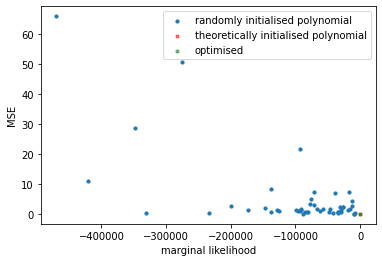

In [72]:
plt.scatter(grids_lml, grids_eva, s=10, label="randomly initialised polynomial")
plt.scatter(model.log_marginal_likelihood().numpy(), evaluate_learnt[0],marker="X",s=10, color="red", label="theoretically initialised polynomial", alpha=0.5)
plt.scatter(model_free.log_marginal_likelihood().numpy(), evaluate_learnt_free[0], s=10, color="green", label="optimised", alpha=0.5)
plt.xlabel("marginal likelihood")
plt.ylabel("MSE")
plt.legend()
plt.savefig("figures/shm_2d_polynomial.pdf")



In [73]:
from scipy.stats import pearsonr
pearsonr(grids_lml, grids_eva)

(-0.6501918072827626, 3.218044477454351e-07)